# File and libraries

In [5]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_0_2024_agg_time_diff_input.csv'


file_tag = "Google Merch Store 2024-2025"


# DSLabs functions

In [6]:
%run "scripts/dslabs_functions.py"


# Data functions

In [7]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [8]:
test_data=True
# test_data=False


data=pd.read_csv(filepath, decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

 
target='Sessions'
series: Series = data[target]

test_split_threshold = 0.8

data.info()

FileNotFoundError: [Errno 2] No such file or directory: 'data/df_merch_0_2024_agg_time_diff_input.csv'

# No Smoothing

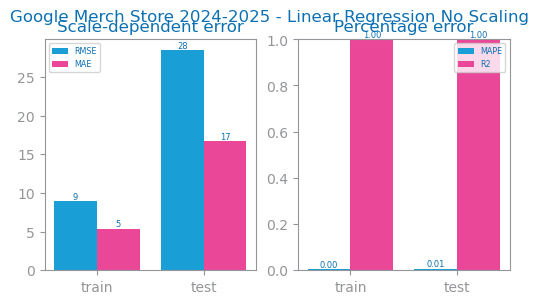

In [ ]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression


data_0 = data.copy()

# Split the data into train and test sets
train_0, test_0 = series_train_test_split(data_0, trn_pct=test_split_threshold)

# Prepare the training and testing data
trnX_0 = train_0.drop(columns=[target])
trnY_0 = train_0[target]
tstX_0 = test_0.drop(columns=[target])
tstY_0 = test_0[target]

# Fit the linear regression model
model_0 = LinearRegression()
model_0.fit(trnX_0, trnY_0)

# Predict the training and testing data
prd_trn_0 = Series(model_0.predict(trnX_0), index=train_0.index)
prd_tst_0 = Series(model_0.predict(tstX_0), index=test_0.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train_0[target], test_0[target], prd_trn_0, prd_tst_0, title=f"{file_tag} - Linear Regression No Scaling")
savefig(f"images/{file_tag}_linear_regression_eval_no_smoothing.png")

## no smoothing plot

<Axes: xlabel='Date', ylabel='Sessions'>

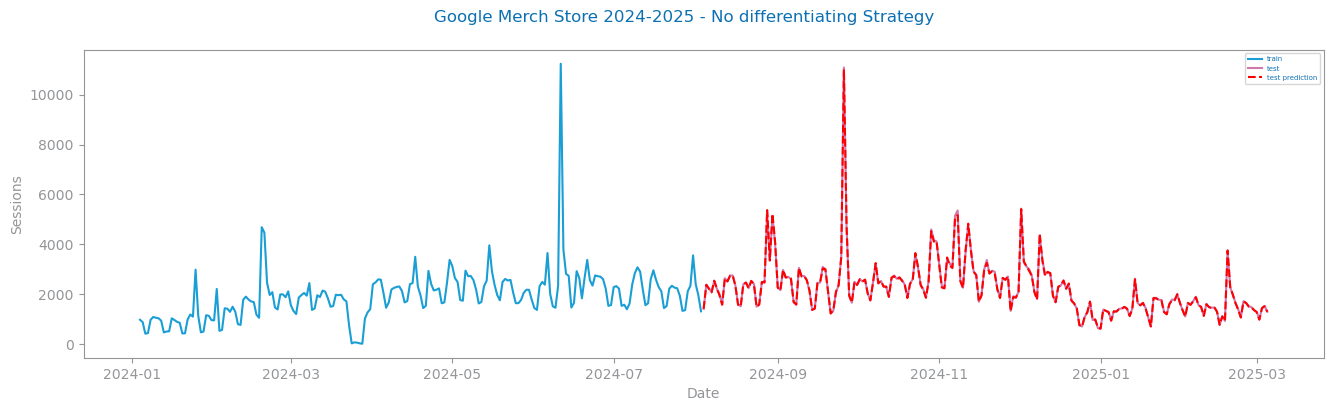

In [ ]:
plot_forecasting_series(
    train_0[target],
    test_0[target],
    prd_tst_0,
    title=f"{file_tag} - No Smoothing Strategy",
    xlabel='Date',
    ylabel=target,
)

# Smoothing

## Smoothing strategy Application

In [ ]:

def apply_strategy_1(df):

    data_copy=df.copy()
    

    # Split the data into train and test sets
    train, test = series_train_test_split(data_copy, trn_pct=test_split_threshold)
    

    WIN_SIZE = 10
    
    #smoothing over the training data
    train_smoothed=train.rolling(window=WIN_SIZE).mean().dropna()

    return train_smoothed, test



train_1,test_1=apply_strategy_1(data)

print(train_1.info())

print(test_1.info())


,Sessions,Seven-day active users,28-day active users,Views,Events per session,Item-list view events,Item view events,Add to baskets,Checkouts,E-commerce purchases,...,Sessions other,Sessions referral,season,commercial_season,week_of_month,day_of_week_nr,is_weekend,is_holiday,is_major_event_day,is_commercial_event_day
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,-95.0,653.0,653.0,-111.0,0.152273,-49.0,-182.0,51.0,-2.0,5.0,...,0.0,-5.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
2024-01-06,-461.0,315.0,315.0,-3080.0,-3.872639,-1681.0,-779.0,-293.0,-55.0,-32.0,...,0.0,-39.0,0.000000,-1.047198,0.0,1.0,1.0,0.0,0.0,0.0
2024-01-07,20.0,333.0,333.0,209.0,3.610865,95.0,41.0,45.0,7.0,8.0,...,0.0,5.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
2024-01-08,535.0,668.0,668.0,2616.0,-2.664253,1538.0,754.0,109.0,17.0,6.0,...,0.0,45.0,0.000000,0.000000,0.0,-6.0,-1.0,0.0,0.0,0.0
2024-01-09,112.0,765.0,765.0,812.0,2.299613,419.0,82.0,72.0,55.0,16.0,...,0.0,-4.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01,-71.0,-39.0,-42.0,-2281.0,-5.248611,-3037.0,-530.0,-175.0,-84.0,-24.0,...,0.0,-113.0,1.570796,1.047198,-4.0,1.0,1.0,0.0,0.0,0.0
2025-03-02,-296.0,-54.0,-90.0,190.0,3.234105,306.0,94.0,18.0,20.0,10.0,...,0.0,-7.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
2025-03-03,449.0,-246.0,-256.0,3302.0,4.114546,3930.0,720.0,187.0,88.0,11.0,...,0.0,149.0,0.000000,0.000000,0.0,-6.0,-1.0,0.0,0.0,0.0


## Differentiation evaluate

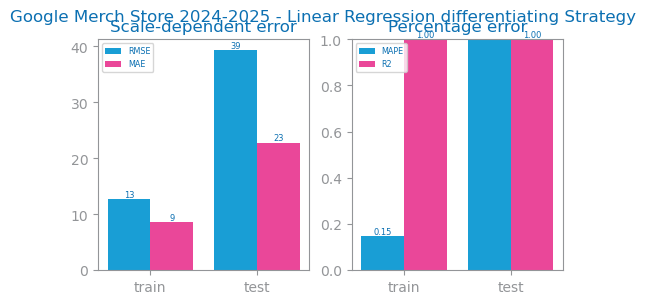

In [ ]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression


# Split the data into train and test sets
# train_1, test_1 = series_train_test_split(data_1, trn_pct=test_split_threshold)

# Prepare the training and testing data
trnX_1 = train_1.drop(columns=[target])
trnY_1 = train_1[target]
tstX_1 = test_1.drop(columns=[target])
tstY_1 = test_1[target]

# Fit the linear regression model
model_1 = LinearRegression()
model_1.fit(trnX_1, trnY_1)

# Predict the training and testing data
prd_trn_1 = Series(model_1.predict(trnX_1), index=train_1.index)
prd_tst_1 = Series(model_1.predict(tstX_1), index=test_1.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train_1[target], test_1[target], prd_trn_1, prd_tst_1, title=f"{file_tag} - Linear Regression differentiating Strategy")
savefig(f"images/{file_tag}_linear_regression_eval_no_scale.png")

## Smoothing Plot

<Axes: xlabel='Date', ylabel='Sessions'>

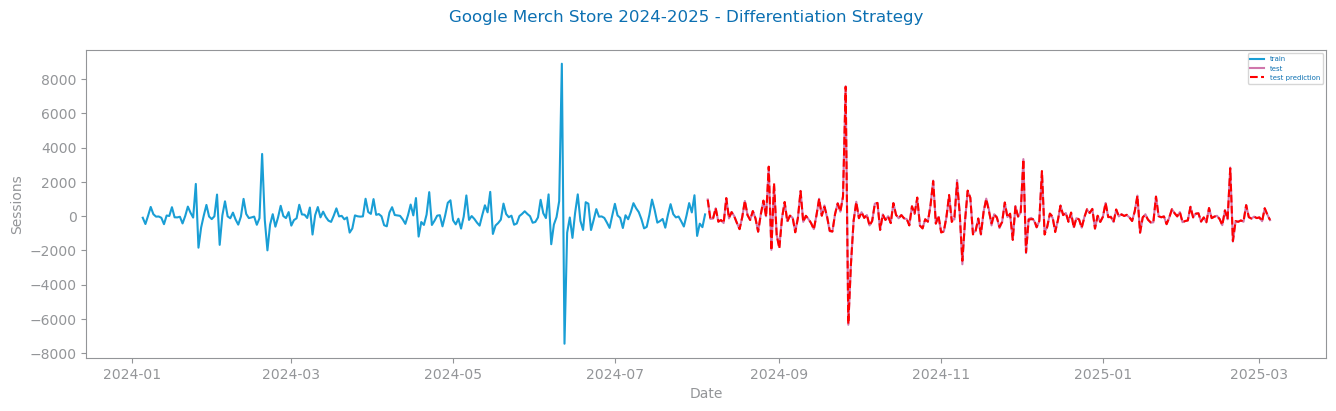

In [ ]:
plot_forecasting_series(
    train_1[target],
    test_1[target],
    prd_tst_1,
    title=f"{file_tag} - Smoothing Strategy",
    xlabel='Date',
    ylabel=target,
)

# Approach uplift comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate performance metrics for each model
metrics = {
    "Model": ["No Smoothing", "Smoothing"],
    "MAE": [
        mean_absolute_error(test_0[target], prd_tst_0),
        mean_absolute_error(test_1[target], prd_tst_1),
    ],
    "MSE": [
        mean_squared_error(test_0[target], prd_tst_0),
        mean_squared_error(test_1[target], prd_tst_1),
    ],
    "RMSE": [
        mean_squared_error(test_0[target], prd_tst_0, squared=False),
        mean_squared_error(test_1[target], prd_tst_1, squared=False),
    ],
    "R²": [
        r2_score(test_0[target], prd_tst_0),
        r2_score(test_1[target], prd_tst_1),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test_0[target], prd_tst_0),
        mean_absolute_percentage_error(test_1[target], prd_tst_1),
    ]
}

# Create a DataFrame to display the metrics
performance_df = pd.DataFrame(metrics)
print(performance_df)

                Model        MAE          MSE       RMSE        R²      MAPE
0  No Differentiation  16.656603   808.179056  28.428490  0.999338  0.669542
1     Differentiation  22.808218  1545.261115  39.309809  0.998537       inf


# save to csv

In [ ]:
if test_data==False:
    

    data_save=data.copy()

    # apply winning strategy
    # data_save=apply_strategy_2(data_save)

    data_save.reset_index(inplace=True)
    
        
    data_save.to_csv(f"data/df_merch_0_2024_agg_time_diff_input.csv", index=False)
    

    print(data_save.columns)